# 02_eda_cleaning_feature_engineering.ipynb

## 1. Objective
This notebook loads the ABT from PostgreSQL, performs data cleaning, and EDA. It then finalizes further features with the cleaned dataset for modeling. Once completed, it generates visualizations for the project README. Finally, it exports a cleaned CSV for use in Tableau.

## 2. Setup

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

import os
from dotenv import load_dotenv

pd.set_option("display.max_columns", None)

## 3. Data Loading
Query the ABT table from the PostgreSQL database.

In [39]:
load_dotenv()

user = os.getenv('PGUSER')
password = os.getenv('PGPASSWORD')
pghost = os.getenv('PGHOST')
pgport = os.getenv('PGPORT')
pgdatabase = os.getenv('PGDATABASE')

engine = create_engine(
    f'postgresql+psycopg2://{user}:{password}@{pghost}:{pgport}/{pgdatabase}')

In [40]:
df = pd.read_sql('SELECT * FROM olist.abt_customer_reorder_180d', engine)
df.head()

,customer_unique_id,first_order_id,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,primary_payment_type,count_payment_installments,count_payment_sequential,used_multiple_payment_types,first_order_category,category_reorder_rate,customer_state,state_median_monthly_income,state_reorder_rate
0,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,0,25.731759,-1.389734,1,69.00,0.249565,3.0,0,NaN,1.055370,credit_card,8.0,1.0,0,stationery,0.019985,SC,1597.0,0.021058
1,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,0,20.037083,-11.108970,1,25.99,0.678338,4.0,1,12.0,1.012396,credit_card,4.0,1.0,0,telephony,0.020025,PA,715.0,0.025952
2,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,0,13.141134,-7.035463,1,180.00,0.093833,5.0,0,NaN,4.937211,credit_card,6.0,1.0,0,telephony,0.020025,SP,1712.0,0.029671
3,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,0,4.375648,-27.643657,1,135.00,0.112000,4.0,0,NaN,6.156933,credit_card,3.0,1.0,0,fashion_bags_accessories,0.046083,RJ,1445.0,0.028071
4,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,2017-07-18 09:23:10,0,16.388646,-11.220266,1,13.90,1.086331,3.0,1,47.0,4.994595,credit_card,2.0,1.0,0,bed_bath_table,0.044457,ES,1205.0,0.031447


## 4. Sanity Checks
The data is relatively clean: 
- Has nulls in columns that originated from the order_reviews table
- Has one row with missing values related to payment information

In [41]:
df['review_response_delay_days'].quantile([0.1,0.99])

0.10     0.817872
0.99    25.595973
Name: review_response_delay_days, dtype: float64

In [42]:
df.shape

(52446, 22)

In [43]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52446 entries, 0 to 52445
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_unique_id                 52446 non-null  object        
 1   first_order_id                     52446 non-null  object        
 2   first_order_timestamp              52446 non-null  datetime64[ns]
 3   reordered_180d                     52446 non-null  int64         
 4   days_to_deliver                    52446 non-null  float64       
 5   actual_vs_estimated_delivery_days  52446 non-null  float64       
 6   first_order_item_count             52446 non-null  int64         
 7   first_order_price                  52446 non-null  float64       
 8   freight_price_ratio                52446 non-null  float64       
 9   first_order_review_score           52058 non-null  float64       
 10  review_comment_flag               

In [44]:
df.describe(include='all')

,customer_unique_id,first_order_id,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,primary_payment_type,count_payment_installments,count_payment_sequential,used_multiple_payment_types,first_order_category,category_reorder_rate,customer_state,state_median_monthly_income,state_reorder_rate
count,52446,52446,52446,52446.000000,52446.000000,52446.000000,52446.000000,52446.000000,52446.000000,52058.000000,52446.000000,21525.000000,52058.000000,52445,52445.000000,52445.000000,52446.000000,52446,52446.000000,52446,52446.000000,52446.000000
unique,52446,52446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,73,NaN,27,NaN,NaN
top,ffffd2657e2aad2907e67c3e9daecbeb,f79a35da168301ae56922475da21117b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN,NaN,bed_bath_table,NaN,SP,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39873,NaN,NaN,NaN,5151,NaN,20862,NaN,NaN
mean,NaN,NaN,2017-09-14 05:30:16.262993920,0.027533,13.403911,-11.713853,1.138981,136.234360,0.304162,4.152369,0.410422,67.039024,3.414170,NaN,3.008924,1.050129,0.025150,NaN,0.027533,NaN,1479.182626,0.027533
min,NaN,NaN,2016-09-15 12:16:38,0.000000,0.533414,-139.397396,1.000000,2.290000,0.000000,1.000000,0.000000,1.000000,0.089225,NaN,1.000000,1.000000,0.000000,NaN,0.000000,NaN,597.000000,0.000000
25%,NaN,NaN,2017-06-23 13:10:31.500000,0.000000,7.479233,-16.346030,1.000000,45.900000,0.132519,4.000000,0.000000,27.000000,1.023536,NaN,1.000000,1.000000,0.000000,NaN,0.019985,NaN,1224.000000,0.026332
50%,NaN,NaN,2017-10-04 20:15:52,0.000000,11.245017,-12.323385,1.000000,85.000000,0.223182,5.000000,0.000000,52.000000,1.679306,NaN,2.000000,1.000000,0.000000,NaN,0.024719,NaN,1597.000000,0.028071
75%,NaN,NaN,2017-12-11 09:16:40,0.000000,16.506253,-7.476655,1.000000,149.900000,0.372308,5.000000,1.000000,92.000000,3.143967,NaN,4.000000,1.000000,0.000000,NaN,0.036432,NaN,1712.000000,0.029671
max,NaN,NaN,2018-02-15 23:45:22,1.000000,209.628611,181.608785,21.000000,13440.000000,5.739496,5.000000,1.000000,207.000000,518.699213,NaN,24.000000,26.000000,1.000000,NaN,0.333333,NaN,2548.000000,0.051724


In [45]:
df.isna().sum()

customer_unique_id                       0
first_order_id                           0
first_order_timestamp                    0
reordered_180d                           0
days_to_deliver                          0
actual_vs_estimated_delivery_days        0
first_order_item_count                   0
first_order_price                        0
freight_price_ratio                      0
first_order_review_score               388
review_comment_flag                      0
review_comment_length                30921
review_response_delay_days             388
primary_payment_type                     1
count_payment_installments               1
count_payment_sequential                 1
used_multiple_payment_types              0
first_order_category                     0
category_reorder_rate                    0
customer_state                           0
state_median_monthly_income              0
state_reorder_rate                       0
dtype: int64

In [46]:
df[df['primary_payment_type'].isna()]

,customer_unique_id,first_order_id,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,primary_payment_type,count_payment_installments,count_payment_sequential,used_multiple_payment_types,first_order_category,category_reorder_rate,customer_state,state_median_monthly_income,state_reorder_rate
26870,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,0,54.813194,36.324745,3,134.97,0.062903,1.0,1,46.0,1.772546,None,NaN,NaN,0,health_beauty,0.029281,SP,1712.0,0.029671


array([[<Axes: title={'center': 'first_order_timestamp'}>,
        <Axes: title={'center': 'reordered_180d'}>,
        <Axes: title={'center': 'days_to_deliver'}>,
        <Axes: title={'center': 'actual_vs_estimated_delivery_days'}>],
       [<Axes: title={'center': 'first_order_item_count'}>,
        <Axes: title={'center': 'first_order_price'}>,
        <Axes: title={'center': 'freight_price_ratio'}>,
        <Axes: title={'center': 'first_order_review_score'}>],
       [<Axes: title={'center': 'review_comment_flag'}>,
        <Axes: title={'center': 'review_comment_length'}>,
        <Axes: title={'center': 'review_response_delay_days'}>,
        <Axes: title={'center': 'count_payment_installments'}>],
       [<Axes: title={'center': 'count_payment_sequential'}>,
        <Axes: title={'center': 'used_multiple_payment_types'}>,
        <Axes: title={'center': 'category_reorder_rate'}>,
        <Axes: title={'center': 'state_median_monthly_income'}>],
       [<Axes: title={'center': 

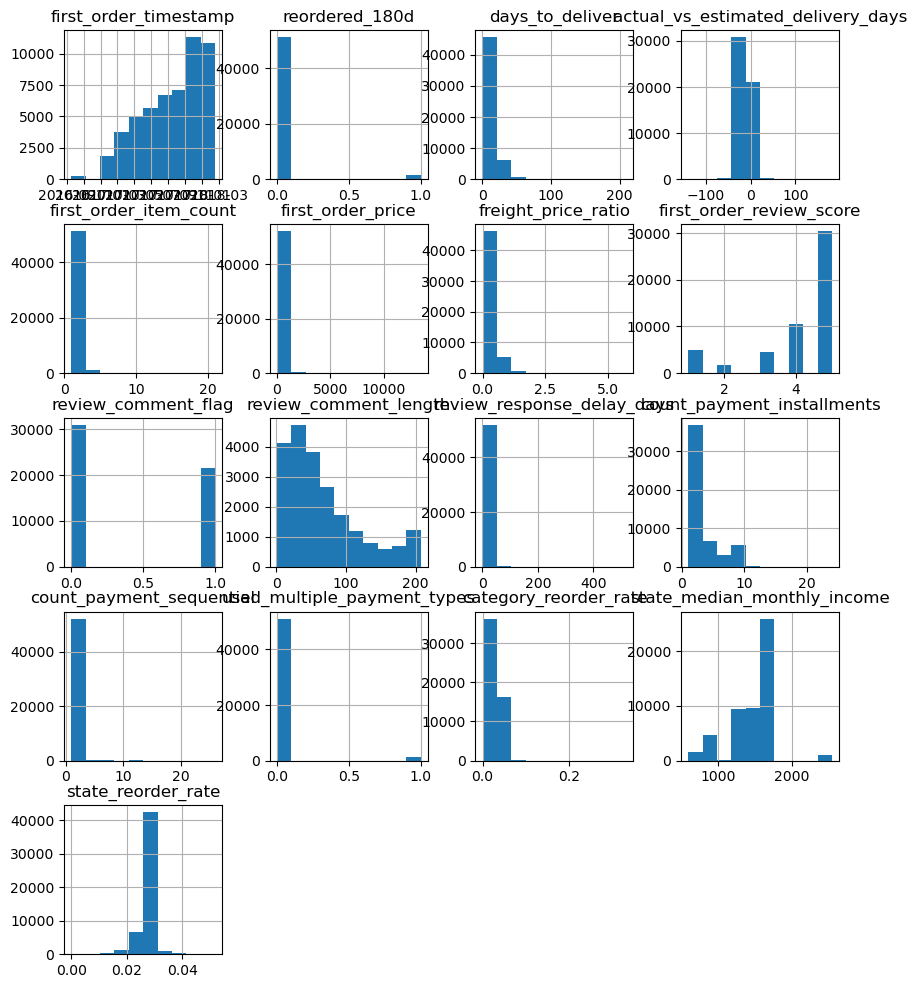

In [47]:
df.hist(figsize=(10, 12))

In [48]:
df['reordered_180d'].value_counts()

reordered_180d
0    51002
1     1444
Name: count, dtype: int64

In [49]:
df['reordered_180d'].value_counts(normalize=True)

reordered_180d
0    0.972467
1    0.027533
Name: proportion, dtype: float64

## 5. Data Cleaning

In [50]:
df_clean = df.copy()

### 5.1 Drop Identifier Columns
Removes non-predictive identifier columns (customer_unique_id & first_order_id). They were necessary for the joins, but they won't work inside our model.

In [51]:
# Drop two identifiers
df_clean = df_clean.drop(columns=['customer_unique_id', 'first_order_id'])
df_clean.head()

,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,primary_payment_type,count_payment_installments,count_payment_sequential,used_multiple_payment_types,first_order_category,category_reorder_rate,customer_state,state_median_monthly_income,state_reorder_rate
0,2017-03-10 21:05:03,0,25.731759,-1.389734,1,69.00,0.249565,3.0,0,NaN,1.055370,credit_card,8.0,1.0,0,stationery,0.019985,SC,1597.0,0.021058
1,2017-10-12 20:29:41,0,20.037083,-11.108970,1,25.99,0.678338,4.0,1,12.0,1.012396,credit_card,4.0,1.0,0,telephony,0.020025,PA,715.0,0.025952
2,2017-11-14 19:45:42,0,13.141134,-7.035463,1,180.00,0.093833,5.0,0,NaN,4.937211,credit_card,6.0,1.0,0,telephony,0.020025,SP,1712.0,0.029671
3,2017-03-04 23:32:12,0,4.375648,-27.643657,1,135.00,0.112000,4.0,0,NaN,6.156933,credit_card,3.0,1.0,0,fashion_bags_accessories,0.046083,RJ,1445.0,0.028071
4,2017-07-18 09:23:10,0,16.388646,-11.220266,1,13.90,1.086331,3.0,1,47.0,4.994595,credit_card,2.0,1.0,0,bed_bath_table,0.044457,ES,1205.0,0.031447


### 5.2 Setting Data Types
Downcasts numeric data types where possible in order to practice memory optimization.

In [52]:
df_clean.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52446 entries, 0 to 52445
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   first_order_timestamp              52446 non-null  datetime64[ns]
 1   reordered_180d                     52446 non-null  int64         
 2   days_to_deliver                    52446 non-null  float64       
 3   actual_vs_estimated_delivery_days  52446 non-null  float64       
 4   first_order_item_count             52446 non-null  int64         
 5   first_order_price                  52446 non-null  float64       
 6   freight_price_ratio                52446 non-null  float64       
 7   first_order_review_score           52058 non-null  float64       
 8   review_comment_flag                52446 non-null  int64         
 9   review_comment_length              21525 non-null  float64       
 10  review_response_delay_days        

In [53]:
# Downcast without data loss, cutting memory usage in half
df_clean = df_clean.astype({
    'reordered_180d': 'Int8',
    'days_to_deliver': 'float32',
    'actual_vs_estimated_delivery_days': 'float32',
    'freight_price_ratio': 'float32',
    'first_order_review_score': 'Int8',
    'first_order_item_count': 'Int16',
    'review_comment_flag': 'Int8',
    'review_comment_length': 'Int16',
    'review_response_delay_days': 'float32',
    'primary_payment_type': 'category',
    'count_payment_installments': 'Int8',
    'count_payment_sequential': 'Int8',
    'used_multiple_payment_types': 'Int8',
    'first_order_category': 'category',
    'category_reorder_rate': 'float32',
    'customer_state': 'category',
    'state_median_monthly_income': 'Int32',
    'state_reorder_rate': 'float32'
})
df_clean.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52446 entries, 0 to 52445
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   first_order_timestamp              52446 non-null  datetime64[ns]
 1   reordered_180d                     52446 non-null  Int8          
 2   days_to_deliver                    52446 non-null  float32       
 3   actual_vs_estimated_delivery_days  52446 non-null  float32       
 4   first_order_item_count             52446 non-null  Int16         
 5   first_order_price                  52446 non-null  float64       
 6   freight_price_ratio                52446 non-null  float32       
 7   first_order_review_score           52058 non-null  Int8          
 8   review_comment_flag                52446 non-null  Int8          
 9   review_comment_length              21525 non-null  Int16         
 10  review_response_delay_days        

### 5.3 Handling Nulls
The Olist review features contain structured missingness:
- Null reviews are unmade reviews
- Null review latency also stems from unmade reviews
- Null comment lengths are unmade comments

These nulls were all imputed with 0, and missingness flags when necessary.

One order stood out in the dataset for lacking payment data.
Being merely one row, it was dropped.

In [54]:
df_clean.isna().sum()

first_order_timestamp                    0
reordered_180d                           0
days_to_deliver                          0
actual_vs_estimated_delivery_days        0
first_order_item_count                   0
first_order_price                        0
freight_price_ratio                      0
first_order_review_score               388
review_comment_flag                      0
review_comment_length                30921
review_response_delay_days             388
primary_payment_type                     1
count_payment_installments               1
count_payment_sequential                 1
used_multiple_payment_types              0
first_order_category                     0
category_reorder_rate                    0
customer_state                           0
state_median_monthly_income              0
state_reorder_rate                       0
dtype: int64

In [55]:
df_clean[df_clean['primary_payment_type'].isna()]

,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,primary_payment_type,count_payment_installments,count_payment_sequential,used_multiple_payment_types,first_order_category,category_reorder_rate,customer_state,state_median_monthly_income,state_reorder_rate
26870,2016-09-15 12:16:38,0,54.813194,36.324745,3,134.97,0.062903,1,1,46,1.772546,NaN,<NA>,<NA>,0,health_beauty,0.029281,SP,1712,0.029671


In [56]:
# Drop the one missing payment info row
df_clean = df_clean.drop(df_clean.index[[26870]]).reset_index(drop=True)

In [57]:
# Create missing-review flag and impute missing review scores with 0
df_clean['review_missing_flag'] = df_clean['first_order_review_score'].isna().astype('Int8')
df_clean['first_order_review_score'] = df_clean['first_order_review_score'].fillna(0)
df_clean['first_order_review_score'].isna().sum()

np.int64(0)

In [58]:
# Fill blank comments with 0 (missingness flag already exists)
df_clean['review_comment_length'] = df_clean['review_comment_length'].fillna(0)
df_clean['review_comment_length'].isna().sum()

np.int64(0)

In [59]:
# Fill null review response time with 0 (fully overlaps with missingness reviews)
df_clean['review_response_delay_days'] = df_clean['review_response_delay_days'].fillna(0)
df_clean['review_response_delay_days'].isna().sum()

np.int64(0)

In [60]:
df_clean.isna().sum()

first_order_timestamp                0
reordered_180d                       0
days_to_deliver                      0
actual_vs_estimated_delivery_days    0
first_order_item_count               0
first_order_price                    0
freight_price_ratio                  0
first_order_review_score             0
review_comment_flag                  0
review_comment_length                0
review_response_delay_days           0
primary_payment_type                 0
count_payment_installments           0
count_payment_sequential             0
used_multiple_payment_types          0
first_order_category                 0
category_reorder_rate                0
customer_state                       0
state_median_monthly_income          0
state_reorder_rate                   0
review_missing_flag                  0
dtype: int64

### 5.4 Handling Outliers
All extreme values were reviewed and appear to represent genuine customer behavior (e.g. unusually high order values or long delivery times) rather than data entry errors.
The final model is a gradient-boosted tree (XGBoost), which is relatively robust to skew and can leverage informative extreme values, several experiments were run (winsorizing, log transforms, and trimming).
In each case, these transformations reduced validation AUC, suggesting that the extremes carry predictive signal.
Therefore, the outliers are retained as-is rather than capped or removed.

## 6. Feature Engineering

### 6.1 Category Feature Dummies

In [61]:
# Create dummies from category features
df_clean = pd.get_dummies(df_clean, columns=['primary_payment_type', 'first_order_category', 'customer_state'], dtype='Int8')
df_clean.head()

,first_order_timestamp,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,count_payment_installments,count_payment_sequential,used_multiple_payment_types,category_reorder_rate,state_median_monthly_income,state_reorder_rate,review_missing_flag,primary_payment_type_boleto,primary_payment_type_credit_card,primary_payment_type_debit_card,primary_payment_type_voucher,first_order_category_agro_industry_and_commerce,first_order_category_air_conditioning,first_order_category_art,first_order_category_arts_and_craftmanship,first_order_category_audio,first_order_category_auto,first_order_category_baby,first_order_category_bed_bath_table,first_order_category_books_general_interest,first_order_category_books_imported,first_order_category_books_technical,first_order_category_cds_dvds_musicals,first_order_category_christmas_supplies,first_order_category_cine_photo,first_order_category_computers,first_order_category_computers_accessories,first_order_category_consoles_games,first_order_category_construction_tools_construction,first_order_category_construction_tools_lights,first_order_category_construction_tools_safety,first_order_category_cool_stuff,first_order_category_costruction_tools_garden,first_order_category_costruction_tools_tools,first_order_category_diapers_and_hygiene,first_order_category_drinks,first_order_category_dvds_blu_ray,first_order_category_electronics,first_order_category_fashio_female_clothing,first_order_category_fashion_bags_accessories,first_order_category_fashion_childrens_clothes,first_order_category_fashion_male_clothing,first_order_category_fashion_shoes,first_order_category_fashion_sport,first_order_category_fashion_underwear_beach,first_order_category_fixed_telephony,first_order_category_flowers,first_order_category_food,first_order_category_food_drink,first_order_category_furniture_bedroom,first_order_category_furniture_decor,first_order_category_furniture_living_room,first_order_category_furniture_mattress_and_upholstery,first_order_category_gaming_computer,first_order_category_garden_tools,first_order_category_health_beauty,first_order_category_home_appliances,first_order_category_home_appliances_2,first_order_category_home_comfort_2,first_order_category_home_confort,first_order_category_home_construction,first_order_category_housewares,first_order_category_industry_commerce_and_business,first_order_category_kitchen_dining_laundry_garden_furniture,first_order_category_la_cuisine,first_order_category_luggage_accessories,first_order_category_market_place,first_order_category_music,first_order_category_musical_instruments,first_order_category_office_furniture,first_order_category_party_supplies,first_order_category_perfumery,first_order_category_pet_shop,first_order_category_security_and_services,first_order_category_signaling_and_security,first_order_category_small_appliances,first_order_category_small_appliances_home_oven_and_coffee,first_order_category_sports_leisure,first_order_category_stationery,first_order_category_tablets_printing_image,first_order_category_telephony,first_order_category_toys,first_order_category_unknown_category,first_order_category_watches_gifts,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,2017-03-10 21:05:03,0,25.731760,-1.389734,1,69.00,0.249565,3,0,0,1.055370,8,1,0,0.019985,1597,0.021058,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### 6.2 Date-Time Features

In [62]:
# Extract the month and dayofweek from the purchase timestamp
df_clean['first_order_month'] = df_clean['first_order_timestamp'].dt.month
df_clean['first_order_weekday'] = df_clean['first_order_timestamp'].dt.dayofweek
df_clean[['first_order_month', 'first_order_weekday']].head()

,first_order_month,first_order_weekday
0,3,4
1,10,3
2,11,1
3,3,5
4,7,1


In [63]:
# Drop the raw timestamp column
df_clean = df_clean.drop(columns=['first_order_timestamp'])
df_clean.head()

,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,count_payment_installments,count_payment_sequential,used_multiple_payment_types,category_reorder_rate,state_median_monthly_income,state_reorder_rate,review_missing_flag,primary_payment_type_boleto,primary_payment_type_credit_card,primary_payment_type_debit_card,primary_payment_type_voucher,first_order_category_agro_industry_and_commerce,first_order_category_air_conditioning,first_order_category_art,first_order_category_arts_and_craftmanship,first_order_category_audio,first_order_category_auto,first_order_category_baby,first_order_category_bed_bath_table,first_order_category_books_general_interest,first_order_category_books_imported,first_order_category_books_technical,first_order_category_cds_dvds_musicals,first_order_category_christmas_supplies,first_order_category_cine_photo,first_order_category_computers,first_order_category_computers_accessories,first_order_category_consoles_games,first_order_category_construction_tools_construction,first_order_category_construction_tools_lights,first_order_category_construction_tools_safety,first_order_category_cool_stuff,first_order_category_costruction_tools_garden,first_order_category_costruction_tools_tools,first_order_category_diapers_and_hygiene,first_order_category_drinks,first_order_category_dvds_blu_ray,first_order_category_electronics,first_order_category_fashio_female_clothing,first_order_category_fashion_bags_accessories,first_order_category_fashion_childrens_clothes,first_order_category_fashion_male_clothing,first_order_category_fashion_shoes,first_order_category_fashion_sport,first_order_category_fashion_underwear_beach,first_order_category_fixed_telephony,first_order_category_flowers,first_order_category_food,first_order_category_food_drink,first_order_category_furniture_bedroom,first_order_category_furniture_decor,first_order_category_furniture_living_room,first_order_category_furniture_mattress_and_upholstery,first_order_category_gaming_computer,first_order_category_garden_tools,first_order_category_health_beauty,first_order_category_home_appliances,first_order_category_home_appliances_2,first_order_category_home_comfort_2,first_order_category_home_confort,first_order_category_home_construction,first_order_category_housewares,first_order_category_industry_commerce_and_business,first_order_category_kitchen_dining_laundry_garden_furniture,first_order_category_la_cuisine,first_order_category_luggage_accessories,first_order_category_market_place,first_order_category_music,first_order_category_musical_instruments,first_order_category_office_furniture,first_order_category_party_supplies,first_order_category_perfumery,first_order_category_pet_shop,first_order_category_security_and_services,first_order_category_signaling_and_security,first_order_category_small_appliances,first_order_category_small_appliances_home_oven_and_coffee,first_order_category_sports_leisure,first_order_category_stationery,first_order_category_tablets_printing_image,first_order_category_telephony,first_order_category_toys,first_order_category_unknown_category,first_order_category_watches_gifts,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,first_order_month,first_order_weekday
0,0,25.731760,-1.389734,1,69.00,0.249565,3,0,0,1.055370,8,1,0,0.019985,1597,0.021058,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [64]:
# Create lateness flag (>= 1 day late counts as late)
df_clean['was_late_flag'] = df_clean['actual_vs_estimated_delivery_days'] >= 1
df_clean['was_late_flag'] = df_clean['was_late_flag'].astype('Int8')
df_clean.head()

,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,count_payment_installments,count_payment_sequential,used_multiple_payment_types,category_reorder_rate,state_median_monthly_income,state_reorder_rate,review_missing_flag,primary_payment_type_boleto,primary_payment_type_credit_card,primary_payment_type_debit_card,primary_payment_type_voucher,first_order_category_agro_industry_and_commerce,first_order_category_air_conditioning,first_order_category_art,first_order_category_arts_and_craftmanship,first_order_category_audio,first_order_category_auto,first_order_category_baby,first_order_category_bed_bath_table,first_order_category_books_general_interest,first_order_category_books_imported,first_order_category_books_technical,first_order_category_cds_dvds_musicals,first_order_category_christmas_supplies,first_order_category_cine_photo,first_order_category_computers,first_order_category_computers_accessories,first_order_category_consoles_games,first_order_category_construction_tools_construction,first_order_category_construction_tools_lights,first_order_category_construction_tools_safety,first_order_category_cool_stuff,first_order_category_costruction_tools_garden,first_order_category_costruction_tools_tools,first_order_category_diapers_and_hygiene,first_order_category_drinks,first_order_category_dvds_blu_ray,first_order_category_electronics,first_order_category_fashio_female_clothing,first_order_category_fashion_bags_accessories,first_order_category_fashion_childrens_clothes,first_order_category_fashion_male_clothing,first_order_category_fashion_shoes,first_order_category_fashion_sport,first_order_category_fashion_underwear_beach,first_order_category_fixed_telephony,first_order_category_flowers,first_order_category_food,first_order_category_food_drink,first_order_category_furniture_bedroom,first_order_category_furniture_decor,first_order_category_furniture_living_room,first_order_category_furniture_mattress_and_upholstery,first_order_category_gaming_computer,first_order_category_garden_tools,first_order_category_health_beauty,first_order_category_home_appliances,first_order_category_home_appliances_2,first_order_category_home_comfort_2,first_order_category_home_confort,first_order_category_home_construction,first_order_category_housewares,first_order_category_industry_commerce_and_business,first_order_category_kitchen_dining_laundry_garden_furniture,first_order_category_la_cuisine,first_order_category_luggage_accessories,first_order_category_market_place,first_order_category_music,first_order_category_musical_instruments,first_order_category_office_furniture,first_order_category_party_supplies,first_order_category_perfumery,first_order_category_pet_shop,first_order_category_security_and_services,first_order_category_signaling_and_security,first_order_category_small_appliances,first_order_category_small_appliances_home_oven_and_coffee,first_order_category_sports_leisure,first_order_category_stationery,first_order_category_tablets_printing_image,first_order_category_telephony,first_order_category_toys,first_order_category_unknown_category,first_order_category_watches_gifts,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,first_order_month,first_order_weekday,was_late_flag
0,0,25.731760,-1.389734,1,69.00,0.249565,3,0,0,1.055370,8,1,0,0.019985,1597,0.021058,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## 7. Post-Cleaning EDA
Main takeaways: The target label, reordered_180d, is highly imbalanced (~2.7% positive). This will affect use of our model.

### 7.1 Data Overview

In [65]:
print("Dataset shape:", df_clean.shape)
print("Number of numeric columns:", df_clean.select_dtypes(include=['number']).shape[1])
print("Number of categorical columns:", df_clean.select_dtypes(include=['object']).shape[1])
print("Number of datetime columns:", df_clean.select_dtypes(include=['datetime64[ns]']).shape[1])

Dataset shape: (52445, 124)
Number of numeric columns: 124
Number of categorical columns: 0
Number of datetime columns: 0


In [66]:
df_clean.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52445 entries, 0 to 52444
Columns: 124 entries, reordered_180d to was_late_flag
dtypes: Int16(2), Int32(1), Int8(112), float32(6), float64(1), int32(2)
memory usage: 13.8 MB


In [67]:
df_clean.describe()

,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,count_payment_installments,count_payment_sequential,used_multiple_payment_types,category_reorder_rate,state_median_monthly_income,state_reorder_rate,review_missing_flag,primary_payment_type_boleto,primary_payment_type_credit_card,primary_payment_type_debit_card,primary_payment_type_voucher,first_order_category_agro_industry_and_commerce,first_order_category_air_conditioning,first_order_category_art,first_order_category_arts_and_craftmanship,first_order_category_audio,first_order_category_auto,first_order_category_baby,first_order_category_bed_bath_table,first_order_category_books_general_interest,first_order_category_books_imported,first_order_category_books_technical,first_order_category_cds_dvds_musicals,first_order_category_christmas_supplies,first_order_category_cine_photo,first_order_category_computers,first_order_category_computers_accessories,first_order_category_consoles_games,first_order_category_construction_tools_construction,first_order_category_construction_tools_lights,first_order_category_construction_tools_safety,first_order_category_cool_stuff,first_order_category_costruction_tools_garden,first_order_category_costruction_tools_tools,first_order_category_diapers_and_hygiene,first_order_category_drinks,first_order_category_dvds_blu_ray,first_order_category_electronics,first_order_category_fashio_female_clothing,first_order_category_fashion_bags_accessories,first_order_category_fashion_childrens_clothes,first_order_category_fashion_male_clothing,first_order_category_fashion_shoes,first_order_category_fashion_sport,first_order_category_fashion_underwear_beach,first_order_category_fixed_telephony,first_order_category_flowers,first_order_category_food,first_order_category_food_drink,first_order_category_furniture_bedroom,first_order_category_furniture_decor,first_order_category_furniture_living_room,first_order_category_furniture_mattress_and_upholstery,first_order_category_gaming_computer,first_order_category_garden_tools,first_order_category_health_beauty,first_order_category_home_appliances,first_order_category_home_appliances_2,first_order_category_home_comfort_2,first_order_category_home_confort,first_order_category_home_construction,first_order_category_housewares,first_order_category_industry_commerce_and_business,first_order_category_kitchen_dining_laundry_garden_furniture,first_order_category_la_cuisine,first_order_category_luggage_accessories,first_order_category_market_place,first_order_category_music,first_order_category_musical_instruments,first_order_category_office_furniture,first_order_category_party_supplies,first_order_category_perfumery,first_order_category_pet_shop,first_order_category_security_and_services,first_order_category_signaling_and_security,first_order_category_small_appliances,first_order_category_small_appliances_home_oven_and_coffee,first_order_category_sports_leisure,first_order_category_stationery,first_order_category_tablets_printing_image,first_order_category_telephony,first_order_category_toys,first_order_category_unknown_category,first_order_category_watches_gifts,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,first_order_month,first_order_weekday,was_late_flag
count,52445.0,52445.000000,52445.000000,52445.0,52445.000000,52445.000000,52445.0,52445.0,52445.0,52445.000000,52445.0,52445.0,52445.0,52445.000000,52445.0,52445.000000,524

In [68]:
df_clean.isna().sum()

reordered_180d                       0
days_to_deliver                      0
actual_vs_estimated_delivery_days    0
first_order_item_count               0
first_order_price                    0
                                    ..
customer_state_SP                    0
customer_state_TO                    0
first_order_month                    0
first_order_weekday                  0
was_late_flag                        0
Length: 124, dtype: int64

### 7.2 Target Distribution

In [69]:
df_clean['reordered_180d'].value_counts(normalize=True)

reordered_180d
0    0.972466
1    0.027534
Name: proportion, dtype: Float64

### 7.3 Correlation with Target

In [70]:
# Features with top 10 positive and top 10 negative correlation with the target
corr_with_label = df_clean.corr()['reordered_180d'].drop('reordered_180d').sort_values(ascending=False)
print(corr_with_label.head(10))
print('\n \n')
print(corr_with_label.tail(10))

category_reorder_rate                            0.064282
first_order_category_bed_bath_table              0.034133
first_order_item_count                           0.024707
count_payment_installments                       0.023480
state_reorder_rate                               0.021790
first_order_category_furniture_decor             0.016788
first_order_category_fashion_bags_accessories    0.016476
first_order_category_sports_leisure              0.016102
first_order_category_diapers_and_hygiene         0.014135
customer_state_SP                                0.010624
Name: reordered_180d, dtype: float64

 

was_late_flag                         -0.009221
first_order_category_watches_gifts    -0.009262
first_order_category_consoles_games   -0.009523
first_order_price                     -0.009616
first_order_category_telephony        -0.010152
first_order_category_auto             -0.011060
first_order_category_toys             -0.011296
actual_vs_estimated_delivery_days     -0.01

### 7.4 Correlation Plot
- Plots a figure of the top 25 strongest absolute correlations with the target
- Saves the figure to /reports/figures/'top_25_correlation_features.png'

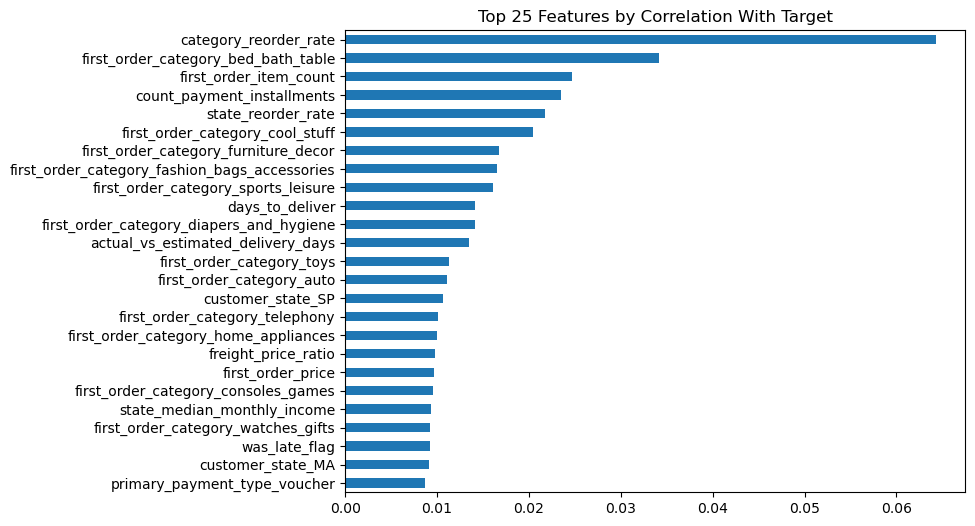

In [71]:
corr = df_clean.corr()['reordered_180d'].drop('reordered_180d')
corr = corr.abs().sort_values(ascending=False)

top_n = 25
corr.head(top_n).sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title(f"Top {top_n} Features by Correlation With Target")

plt.savefig(
    '../assets/figures/top_25_correlation_features.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()


## 8. Define Modeling Dataset

In [72]:
df_model = df_clean.copy()
df_model.head()

,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,count_payment_installments,count_payment_sequential,used_multiple_payment_types,category_reorder_rate,state_median_monthly_income,state_reorder_rate,review_missing_flag,primary_payment_type_boleto,primary_payment_type_credit_card,primary_payment_type_debit_card,primary_payment_type_voucher,first_order_category_agro_industry_and_commerce,first_order_category_air_conditioning,first_order_category_art,first_order_category_arts_and_craftmanship,first_order_category_audio,first_order_category_auto,first_order_category_baby,first_order_category_bed_bath_table,first_order_category_books_general_interest,first_order_category_books_imported,first_order_category_books_technical,first_order_category_cds_dvds_musicals,first_order_category_christmas_supplies,first_order_category_cine_photo,first_order_category_computers,first_order_category_computers_accessories,first_order_category_consoles_games,first_order_category_construction_tools_construction,first_order_category_construction_tools_lights,first_order_category_construction_tools_safety,first_order_category_cool_stuff,first_order_category_costruction_tools_garden,first_order_category_costruction_tools_tools,first_order_category_diapers_and_hygiene,first_order_category_drinks,first_order_category_dvds_blu_ray,first_order_category_electronics,first_order_category_fashio_female_clothing,first_order_category_fashion_bags_accessories,first_order_category_fashion_childrens_clothes,first_order_category_fashion_male_clothing,first_order_category_fashion_shoes,first_order_category_fashion_sport,first_order_category_fashion_underwear_beach,first_order_category_fixed_telephony,first_order_category_flowers,first_order_category_food,first_order_category_food_drink,first_order_category_furniture_bedroom,first_order_category_furniture_decor,first_order_category_furniture_living_room,first_order_category_furniture_mattress_and_upholstery,first_order_category_gaming_computer,first_order_category_garden_tools,first_order_category_health_beauty,first_order_category_home_appliances,first_order_category_home_appliances_2,first_order_category_home_comfort_2,first_order_category_home_confort,first_order_category_home_construction,first_order_category_housewares,first_order_category_industry_commerce_and_business,first_order_category_kitchen_dining_laundry_garden_furniture,first_order_category_la_cuisine,first_order_category_luggage_accessories,first_order_category_market_place,first_order_category_music,first_order_category_musical_instruments,first_order_category_office_furniture,first_order_category_party_supplies,first_order_category_perfumery,first_order_category_pet_shop,first_order_category_security_and_services,first_order_category_signaling_and_security,first_order_category_small_appliances,first_order_category_small_appliances_home_oven_and_coffee,first_order_category_sports_leisure,first_order_category_stationery,first_order_category_tablets_printing_image,first_order_category_telephony,first_order_category_toys,first_order_category_unknown_category,first_order_category_watches_gifts,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,first_order_month,first_order_weekday,was_late_flag
0,0,25.731760,-1.389734,1,69.00,0.249565,3,0,0,1.055370,8,1,0,0.019985,1597,0.021058,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## 9. Save Clean Data as File

In [73]:
# Save clean dataset for analytics
df_clean.to_csv('../data/processed/df_clean.csv', index=False)

In [74]:
# Save modeling dataset
df_model.to_csv('../data/processed/df_model.csv', index=False)